In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
#import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import contractions

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Download the dataset
df_combined = pd.read_csv('/content/cropped_df.csv')

df_combined.head(2)

,text,main_category
0,['i am not angry at him i kindda let my negati...,anger
1,['i have been comfort eating because i am all ...,anger


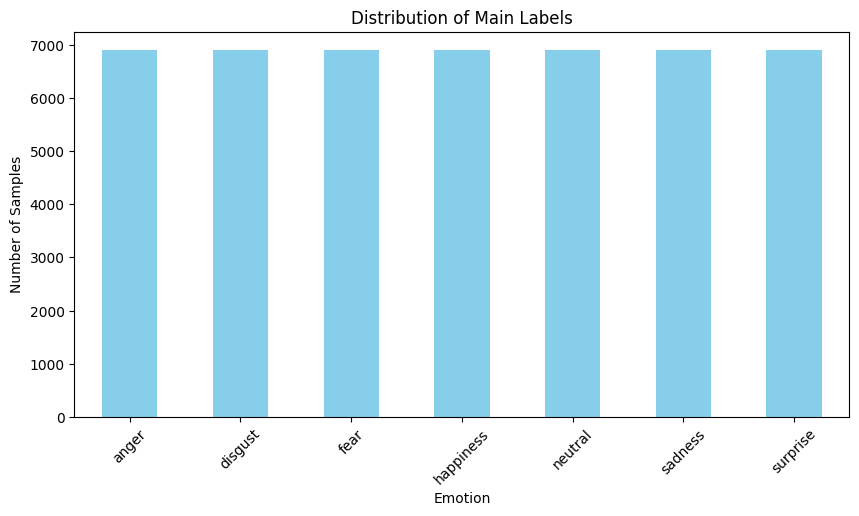

In [ ]:
# Count the occurrences of each main_label category
label_counts = df_combined['main_category'].value_counts()

# Plot distribution
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Main Labels")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Print for troubleshooting
text_counts = df_combined['text'].value_counts()
print(text_counts.head(20)) 

text
['i am not angry at him i kindda let my negative feelings towards him away but something is still bothering me maybe i m a little bit jealous at him because he won for him it was wanton to let things run low and have fun whereas at my side things aren t that simpleton']    1
['look. if you ridicule scarce convey a quick drive home.']                                                                                                                                                                                                                       1
['squad, interplaces. euromast. check tune, hombre.']                                                                                                                                                                                                                             1
['and i am going to put some things into signaling.']                                                                                                                  

In [ ]:
import spacy

# Download the English model for spaCy
# Used for POS tagging
# used sentiment_scores
# Used TfidfVectorizer
#  used negation_counts 

nlp = spacy.load("en_core_web_sm")

# Function to clean text
POS_TAGS = ["NOUN", "VERB", "ADJ", "ADV", "PRON", "PROPN", "NUM", "INTJ"]
def get_pos_vector(text):
    doc = nlp(text)
    counts = {tag: 0 for tag in POS_TAGS}
    for token in doc:
        if token.pos_ in POS_TAGS:
            counts[token.pos_] += 1
    return [counts[tag] for tag in POS_TAGS]

pos_features = np.array([get_pos_vector(txt) for txt in df_combined['text']])
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# Function to get sentiment scores
sentiment_scores = np.array([get_sentiment_score(txt) for txt in df_combined['text']]).reshape(-1, 1)

# TFIDF Vectorization
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df_combined['text']).toarray()

# Function to count negations
def get_negation_count(text):
    negations = {"not", "never", "no", "n't"}
    tokens = text.lower().split()
    return sum(1 for t in tokens if t in negations)

negation_counts = np.array([get_negation_count(txt) for txt in df_combined['text']]).reshape(-1, 1)

# Combine all features
extra_features = np.hstack([
    pos_features,
    sentiment_scores,

    tfidf_matrix,
    negation_counts
])

print("extra_features shape:", extra_features.shape)

extra_features shape: (48279, 510)


In [ ]:
# Sanity check
df = df_combined.copy()

In [ ]:
label_encoder = LabelEncoder()

# 
df['label'] = label_encoder.fit_transform(df['main_category'])
num_classes = df['label'].nunique()
print("Unique Classes:", list(label_encoder.classes_))

texts = df['text'].values
labels = df['label'].values
MAX_LENGTH = 300 # Maximum length of text sequences
OOV_TOKEN = "<OOV>" # Out of Vocabulary token
tokenizer = Tokenizer(oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(texts) # Fit the tokenizer on the texts
sequences = tokenizer.texts_to_sequences(texts) # Convert texts to sequences
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab Size:", vocab_size) # Vocabulary size

padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
y_onehot = to_categorical(labels, num_classes=num_classes)

Unique Classes: ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Vocab Size: 25545


In [ ]:
# Create train, validation, and test sets
X_seq = padded_sequences
X_ext = extra_features

X_seq, X_test_seq, X_ext, X_test_ext, y_train, y_test = train_test_split(
    X_seq, X_ext, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)
X_seq, X_val_seq, X_ext, X_val_ext, y_train, y_val = train_test_split(
    X_seq, X_ext, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# Print the shapes
print("Train seq shape:", X_seq.shape, "Train ext shape:", X_ext.shape)
print("Val seq shape:", X_val_seq.shape, "Val ext shape:", X_val_ext.shape)
print("Test seq shape:", X_test_seq.shape, "Test ext shape:", X_test_ext.shape)


Train seq shape: (34760, 300) Train ext shape: (34760, 510)
Val seq shape: (3863, 300) Val ext shape: (3863, 510)
Test seq shape: (9656, 300) Test ext shape: (9656, 510)


In [ ]:
# Glove Embeddings
EMBEDDING_DIM = 300 # Dimension of GloVe embeddings
embedding_index = {}
glove_path = "/content/glove.6B.300d.txt" # Path to GloVe embeddings
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32') # 300D
        embedding_index[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for w, i in word_index.items():
    if w in embedding_index:
        embedding_matrix[i] = embedding_index[w] # Assign the embedding vector
nonzero_rows = np.count_nonzero(np.sum(embedding_matrix, axis=1)) # Count non-zero rows
print("Non-zero Embeddings:", nonzero_rows, "/", vocab_size)

Non-zero Embeddings: 17406 / 25545


In [ ]:
# F1 Metric
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred, 'float'), axis=0)
    actual_positives = K.sum(K.cast(y_true, 'float'), axis=0)
    precision = tp / (predicted_positives + K.epsilon())
    recall = tp / (actual_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Sequence branch
sequence_input = Input(shape=(MAX_LENGTH,), name="sequence_input")
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

# Model
model = Model(inputs=sequence_input, outputs=output)

# compile the model
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_metric]
)

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_input (InputLayer  [(None, 300)]             0         
 )                                                               
                                                                 
 embedding (Embedding)       (None, 300, 300)          7663500   
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          186880    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 300, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                       

In [ ]:
# set up lerning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
EPOCHS = 50
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/50
1087/1087 [==============================] - 420s 377ms/step - loss: 1.6268 - accuracy: 0.3421 - f1_metric: 0.1511 - val_loss: 1.6052 - val_accuracy: 0.3319 - val_f1_metric: 0.1969 - lr: 1.0000e-04
Epoch 2/50
1087/1087 [==============================] - 397s 365ms/step - loss: 1.2682 - accuracy: 0.4865 - f1_metric: 0.2719 - val_loss: 2.5305 - val_accuracy: 0.2493 - val_f1_metric: 0.1475 - lr: 1.0000e-04
Epoch 3/50
1087/1087 [==============================] - 402s 370ms/step - loss: 1.0705 - accuracy: 0.5804 - f1_metric: 0.3895 - val_loss: 0.9231 - val_accuracy: 0.6428 - val_f1_metric: 0.5104 - lr: 1.0000e-04
Epoch 4/50
1087/1087 [==============================] - 390s 359ms/step - loss: 0.8691 - accuracy: 0.6787 - f1_metric: 0.5546 - val_loss: 0.7375 - val_accuracy: 0.7398 - val_f1_metric: 0.6466 - lr: 1.0000e-04
Epoch 5/50
1087/1087 [==============================] - 388s 357ms/step - loss: 0.6848 - accuracy: 0.7635 - f1_metric: 0.7036 - val_loss: 1.1122 - val_accuracy: 0.6

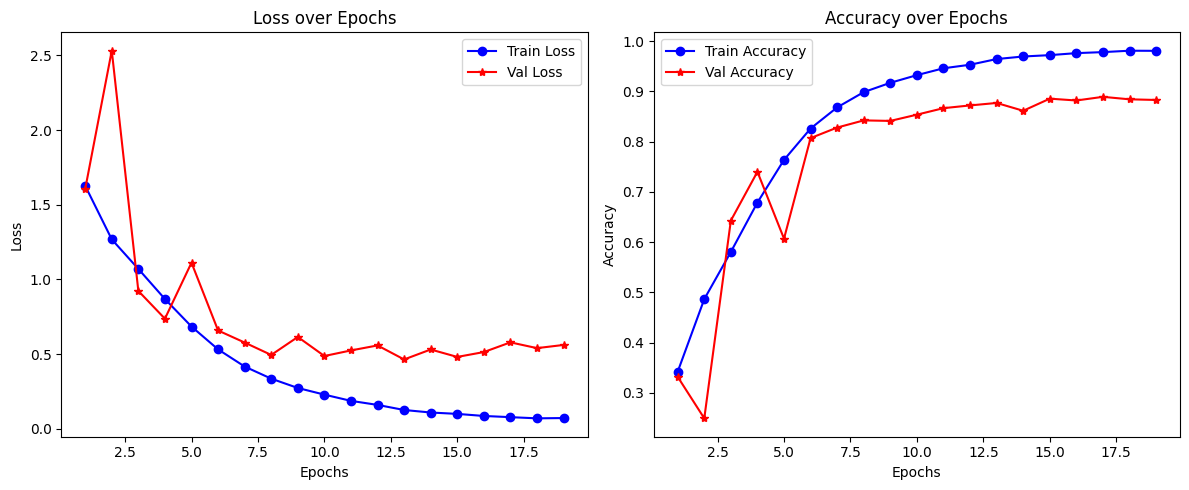

In [ ]:
# Evaluate the model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, 'b-o', label="Train Loss")
plt.plot(epochs_range, val_loss, 'r-*', label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, 'b-o', label="Train Accuracy")
plt.plot(epochs_range, val_acc, 'r-*', label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Classification Report
y_test_probs = model.predict(X_test_seq)
y_test_pred = np.argmax(y_test_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

302/302 [==============================] - 28s 92ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.94      0.82      0.88      1380
     disgust       0.99      1.00      0.99      1379
        fear       0.85      0.87      0.86      1380
   happiness       0.91      0.74      0.82      1380
     neutral       0.91      0.93      0.92      1379
     sadness       0.72      0.87      0.79      1379
    surprise       0.85      0.91      0.88      1379

    accuracy                           0.88      9656
   macro avg       0.88      0.88      0.88      9656
weighted avg       0.88      0.88      0.88      9656



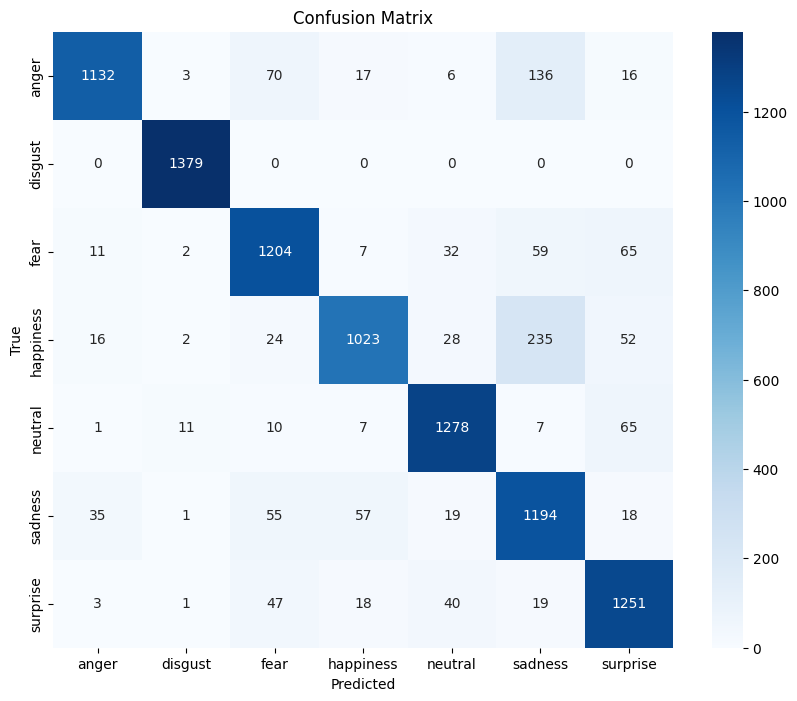

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

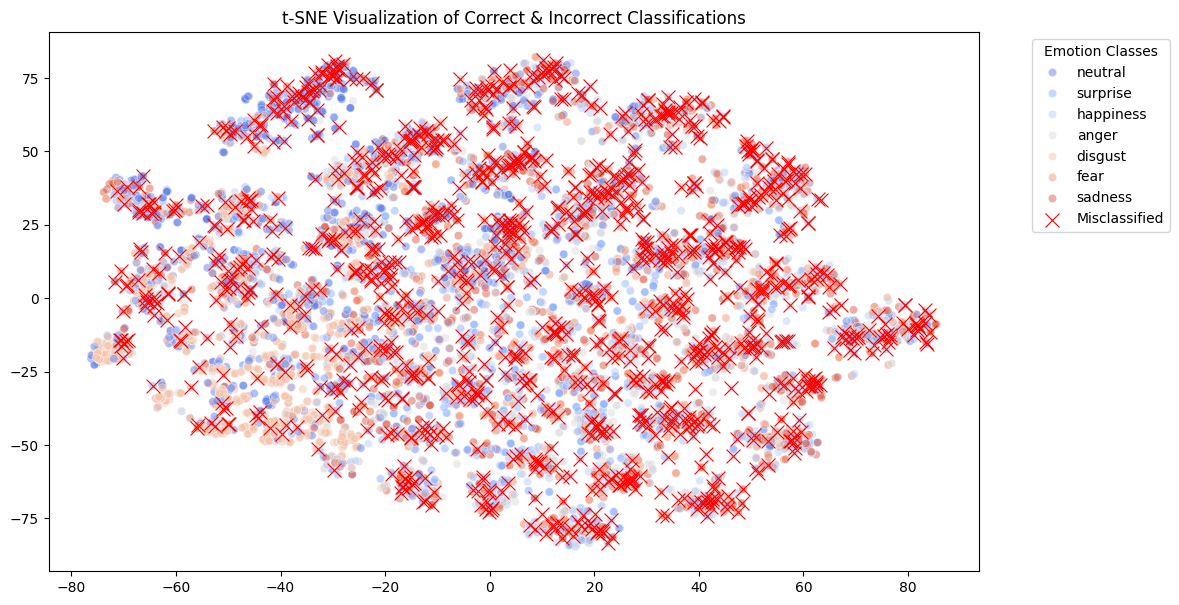

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert embeddings to 2D space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_test_embedded = tsne.fit_transform(X_test_seq)

# Get true and predicted labels
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(y_test_probs, axis=1)

# Identify misclassified points
incorrect_idxs = np.where(y_test_true != y_test_pred)[0]

# Convert numeric labels to class names
class_labels = label_encoder.classes_  # Extract emotion names
y_test_labels = [class_labels[i] for i in y_test_true]  # True labels as text

plt.figure(figsize=(12, 7))

# Plot correct classifications with actual class names
sns.scatterplot(x=X_test_embedded[:, 0], y=X_test_embedded[:, 1],
                hue=y_test_labels, palette='coolwarm', alpha=0.5, legend=True)

# Overlay misclassified points with red crosses
sns.scatterplot(x=X_test_embedded[incorrect_idxs, 0], y=X_test_embedded[incorrect_idxs, 1],
                color='red', marker="x", s=100, label="Misclassified")

plt.title("t-SNE Visualization of Correct & Incorrect Classifications")
plt.legend(title="Emotion Classes", bbox_to_anchor=(1.05, 1), loc='upper left')  # Better legend placement
plt.show()


In [17]:
# Extract misclassified examples
misclassified_indices = incorrect_idxs[:100]  # Show first 10 misclassified sentences

print("Misclassified Sentences:")
for i in misclassified_indices:
    true_label = label_encoder.inverse_transform([y_test_true[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0]

    print(f"Text: {df_combined.iloc[i]['text']}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 100)


Misclassified Sentences:
Text: ['i have be highly critical of dennis covingtons book in this article i must admit that he did say something that has deserve in this discussion when he noted in his closing chapters this feeling after idol is a dangerous business']
True Label: happiness
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: ['i experience very bothered about the lack of time ane get to find aspiration']
True Label: anger
Predicted Label: fear
----------------------------------------------------------------------------------------------------
Text: ['i buttocks feel she still furious with pine tree state']
True Label: fear
Predicted Label: sadness
----------------------------------------------------------------------------------------------------
Text: ['iodin represent feeling really charge for some reason i think it coz i am confused']
True Label: surprise
Predicted Label: fear
----------------

In [19]:
# save model
model.save('model6.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results

The model performs well at 88% accuracy, but it has several problems sutch as:

- **Overfiting  after a few epochs**

Solutions: <br>
Increase dropout in the model<br>
Use L2 regularization<br>
Change data aggmentation method <br>
Change early stopping values <br>

- **Classification Report**<br>
Disgust has an F1-score of 0.99 coild be a problem as most o the data is syntetic<br>
Happiness has a lower recall (0.74) compared to its precision (0.91), suggesting many happiness examples are misclassified<br>
Sadness has lower precision (0.72), meaning many examples labeled as sadness were actually from other categories <br>

Solution:<br>
The model struggles to separate happiness from similar emotions like neutral or surprise. Try other embeding methods<br>
Many examples classified as sadness were actually other emotions (false positives). Adjust class weights <br>

- **Confusion Matrix**

"Happiness" is often confused with "Neutral" and "Sadness"<br>
"Fear" has some confusion with "Sadness" and "Neutral" <br>
"Surprise" is mistaken for "Fear" and vice versa <br>
"Anger" has some confusion with "Fear"<br>

Solution: <br>
Semantic Overlap: Some emotions share common expressions or words (e.g., "I was so excited, I almost cried" could be classified as happiness or sadness).Use context-aware embeddings

- **t-SNE Visualization**

The correct classifications are well-clustered, meaning the model has learned useful patterns. <br>
The misclassified points (red crosses) are scattered across multiple clusters, especially in overlapping emotion spaces.  <br>
This suggests the model struggles with subtle emotional nuances. <br>

Solution:<br>
Use context-aware embeddings<br>
Add more vocabulary <br>
Use context-aware embeddings <br>

- **Misclassified Sentences**
Happiness vs. Neutral/Sadness: Sentences with mild positivity (e.g., “I feel satisfied”) get misclassified as neutral or sadness instead of happiness. <br>
Anger vs. Fear/Sadness: Expressions of frustration or stress sometimes get classified as fear or sadness instead. <br>
Surprise vs. Fear: Sentences with unexpected emotions sometimes get labeled as fear instead of surprise <br>

Solution <br>
Emotion Amplification: Use sentiment intensity features to distinguish between "mild happiness" and "strong happiness."